## Initialization

In [1]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [2]:
labels = pd.read_csv("/datasets/faces/labels.csv")
train_datagen = ImageDataGenerator(rescale=1./255)

In [3]:
train_gen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,                
    directory='/datasets/faces/final_files/',  
    x_col='file_name',               
    y_col='real_age',                
    target_size=(224, 224),          
    batch_size=32,                   
    class_mode='raw',                
    seed=12345                       
)

Found 7591 validated image filenames.


## EDA

Dataset Size: (7591, 2)


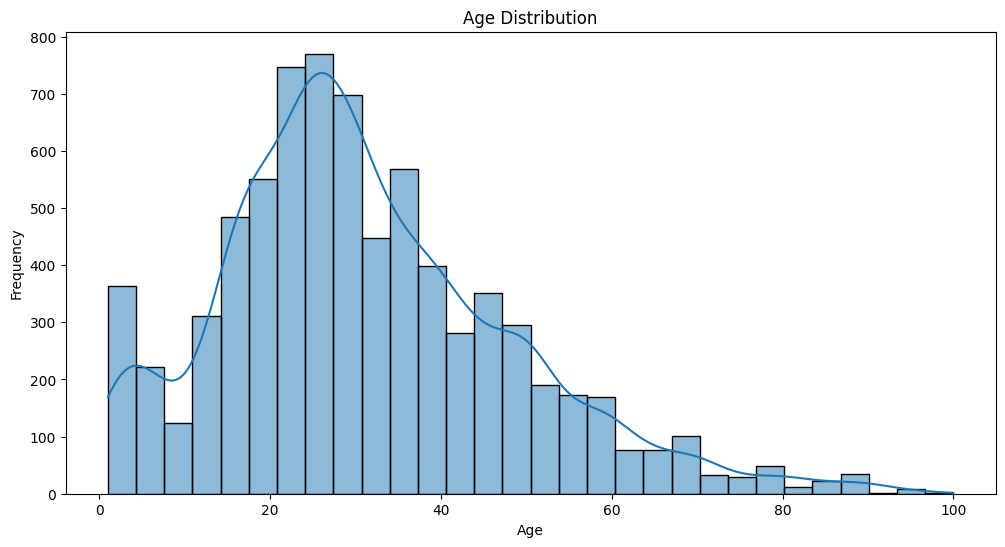

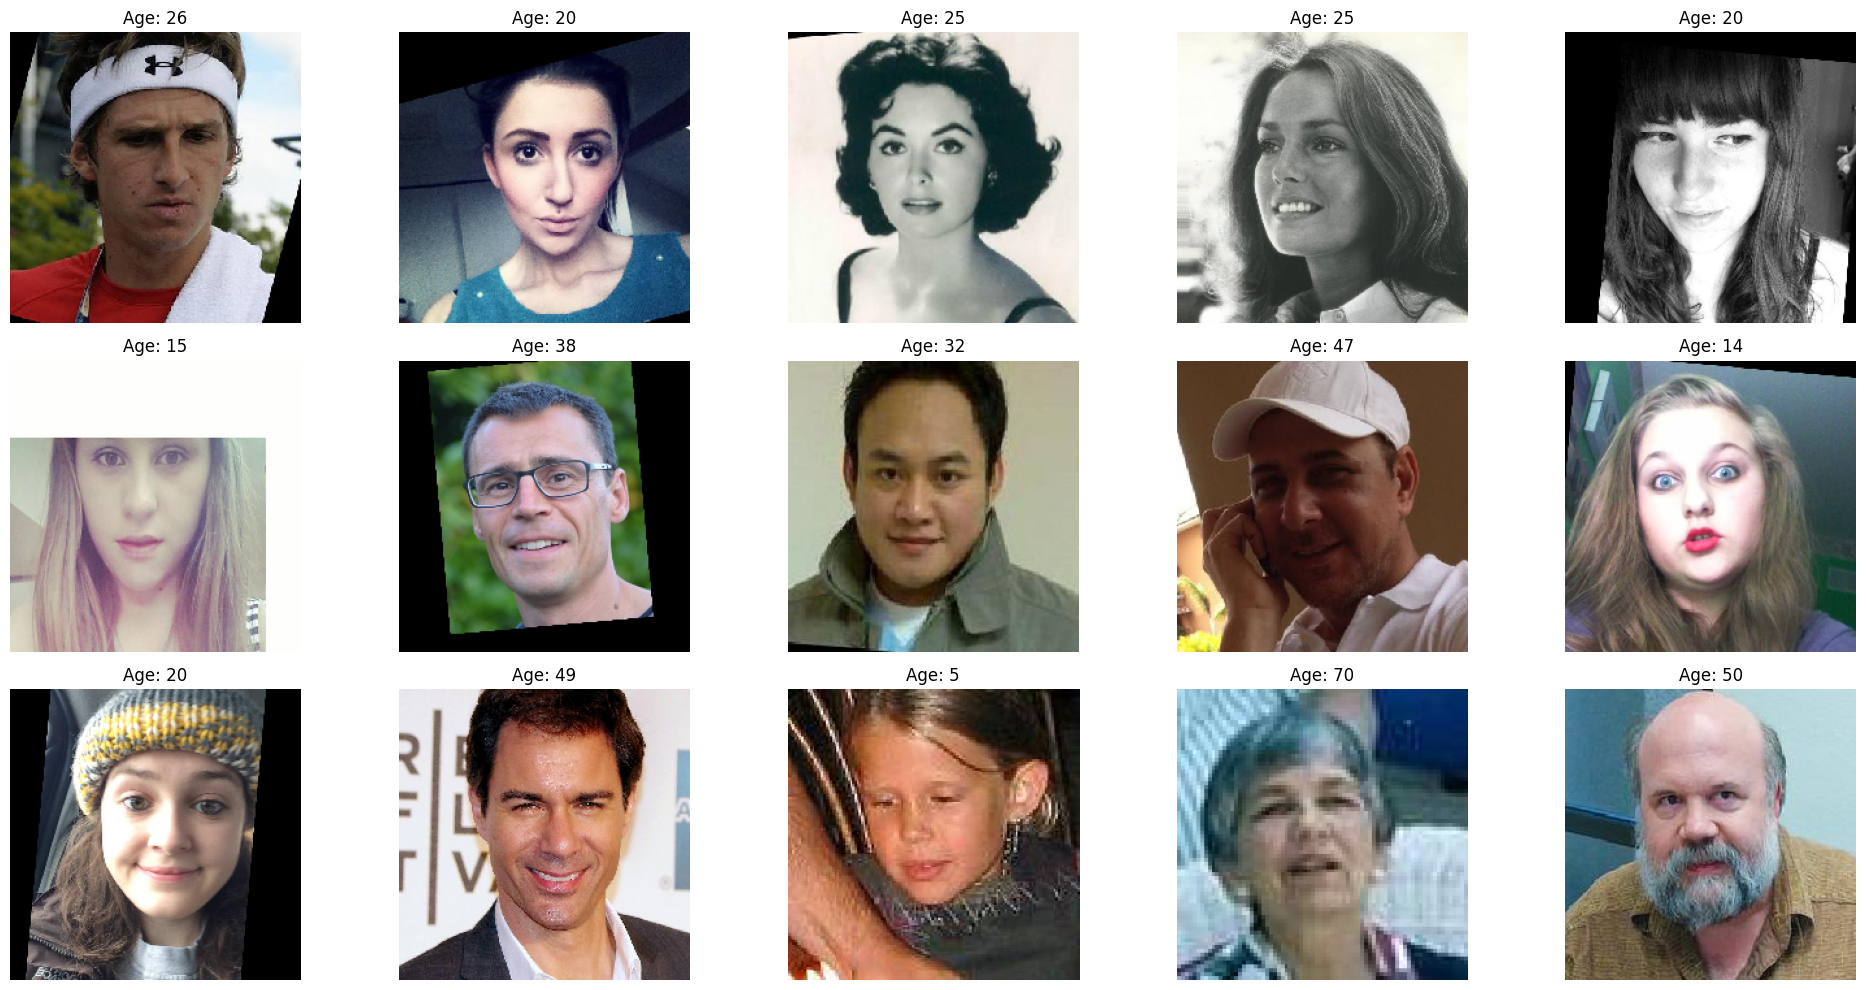

In [4]:
print("Dataset Size:", labels.shape)

# 2. Explore Age Distribution
plt.figure(figsize=(12,6))
sns.histplot(labels['real_age'], bins=30, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# 3. Visualize Sample Images
def plot_sample_images(df, directory, num_samples=15):
    plt.figure(figsize=(20, 10))
    sample_df = df.sample(num_samples)
    for i, (index, row) in enumerate(sample_df.iterrows()):
        file_name = row['file_name']
        age = row['real_age']
        img = load_img(directory + file_name, target_size=(224, 224))
        plt.subplot(3, 5, i+1)
        plt.imshow(img)
        plt.title(f'Age: {age}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_sample_images(labels, '/datasets/faces/final_files/')

### Findings

Age Distribution
Range and Spread:
The ages in the dataset range from 0 to 100 years.
There is a high concentration of faces in the age range of approximately 15 to 30 years.
Frequency and Density:
The peak frequency occurs around ages 20-25.
The number of samples decreases as the age increases beyond 30.
There are fewer samples in the higher age ranges (e.g., 60+), which might affect the model's performance in predicting the ages for these groups.
Potential Imbalances:
The dataset is somewhat imbalanced. There are more samples of younger people compared to older ones. This could lead to a bias in the model, where the model performs better on younger faces and worse on older faces.

Sample Image Visualization
Diversity:
The sample images show a good diversity in terms of gender, apparent ethnicity, and age.
Each image is accompanied by its corresponding age, which will be used as the target for the model.
Quality and Variability:
The images are of varied quality and lighting conditions, which could help the model generalize better.
The orientations of some images may need to be addressed (e.g., rotated images).
Age Appearance:
Visually, it is evident that age prediction from facial images can be challenging due to the varying appearance of aging. Some people may appear younger or older than their actual age due to various factors.

Considerations for Model Training
Addressing Imbalances:
Since the dataset has more younger samples, consider techniques like data augmentation or over-sampling of the underrepresented age groups.
Alternatively, adjust the loss function to give more weight to older age predictions to mitigate imbalance effects.
Preprocessing:
Ensure the images are properly aligned and oriented. Consider using techniques to rotate or flip images to standardize their orientation.
Perform normalization, as done with the rescale=1./255 parameter in ImageDataGenerator.
Validation:
Given the imbalance, ensure that the validation set is representative of the entire dataset to get a true indication of model performance. You may consider stratified sampling for splitting the dataset.
Model Evaluation:
Monitor the performance of the model across different age groups. Ensure it is not heavily biased towards predicting ages within the range of high-frequency age groups.


## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [5]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [7]:
def load_train(path):
    """
    It loads the train part of dataset from path
    """
    # Load the labels CSV file as a pandas DataFrame
    labels = pd.read_csv(path + 'labels.csv')
    
    # Create an ImageDataGenerator with validation split
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    
    # Using the ImageDataGenerator, create a generator for the training subset
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,                # The DataFrame containing the file names and labels
        directory=f"{path}final_files/", # The directory containing the image files
        x_col='file_name',               # Column in the DataFrame that contains the image file names
        y_col='real_age',                # Column in the DataFrame that contains the labels
        target_size=(224, 224),          # Resize the images to 224x224 pixels
        batch_size=32,                   # Number of images to read at once
        class_mode='raw',                # Use 'raw' since it's a regression problem
        subset='training',               # Specify subset as training
        seed=12345                       # Random seed for reproducibility
    )
    return train_gen_flow

In [8]:
def load_test(path):
    """
    It loads the test part of dataset from path
    """
    # Load the labels CSV file as a pandas DataFrame
    labels = pd.read_csv(path + 'labels.csv')
    
    # Create an ImageDataGenerator with validation split
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    
    # Using the ImageDataGenerator, create a generator for the validation subset
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,                # The DataFrame containing the file names and labels
        directory=f"{path}final_files/", # The directory containing the image files
        x_col='file_name',               # Column in the DataFrame that contains the image file names
        y_col='real_age',                # Column in the DataFrame that contains the labels
        target_size=(224, 224),          # Resize the images to 224x224 pixels
        batch_size=32,                   # Number of images to read at once
        class_mode='raw',                # Use 'raw' since it's a regression problem
        subset='validation',             # Specify subset as validation
        seed=12345                       # Random seed for reproducibility
    )

    return test_gen_flow

In [9]:
def load_test(path):
    """
    It loads the test part of dataset from path
    """
    # Load the labels CSV file as a pandas DataFrame
    labels = pd.read_csv(path + 'labels.csv')
    
    # Create an ImageDataGenerator with validation split for the test set
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    
    # Using the ImageDataGenerator, create a generator for the validation subset
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,                # The DataFrame containing the file names and labels
        directory=f"{path}final_files/", # The directory containing the image files
        x_col='file_name',               # Column in the DataFrame that contains the image file names
        y_col='real_age',                # Column in the DataFrame that contains the labels
        target_size=(224, 224),          # Resize the images to 224x224 pixels
        batch_size=32,                   # Number of images to read at once
        class_mode='raw',                # Use 'raw' since it's a regression problem
        subset='validation',             # Specify subset as validation
        seed=12345                       # Random seed for reproducibility
    )

    return test_gen_flow

In [10]:
def create_model(input_shape):
    """
    It defines the model
    """
    
    # Load the ResNet50 model pre-trained on ImageNet, excluding the top (fully-connected) layers
    backbone = ResNet50(weights='imagenet', 
                        input_shape=input_shape,
                        include_top=False)

    # Define the model
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    # Compile the model
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

In [11]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    """
    Trains the model given the parameters
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
        
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [12]:
# Define initialization imports
init_str = """
import pandas as pd
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
"""

# Import inspect module to get the source code of functions
import inspect

# Write initial imports and function definitions to the script
with open('run_model_on_gpu.py', 'w') as f:
    f.write(init_str)
    f.write('\n\n')
    
    for fn_name in [load_train, load_test, create_model, train_model]:
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

# Define the main script execution part
main_str = """
if __name__ == "__main__":
    # Paths to the datasets
    train_data_path = "/datasets/faces"  # Update this
    test_data_path = "/datasets/faces"   # Update this
    
    # Load the training and test data
    train_data = load_train(train_data_path)
    test_data = load_test(test_data_path)
    
    # Define the input shape
    input_shape = (224, 224, 3)
    
    # Create the model
    model = create_model(input_shape)
    
    # Train the model
    model = train_model(model, train_data, test_data, epochs=20)
    
    # Save the model
    model.save("age_prediction_model.h5")
"""

# Append the main script execution to the script file
with open('run_model_on_gpu.py', 'a') as f:
    f.write(main_str)

### Output

Place the output from the GPU platform as an Markdown cell here.

## Training Output

Epoch 1/20
356/356 - 35s - loss: 95.3532 - mae: 7.4339 - val_loss: 124.3362 - val_mae: 8.4921

Epoch 2/20
356/356 - 35s - loss: 76.8372 - mae: 6.6707 - val_loss: 127.6357 - val_mae: 8.6035

...

Epoch 19/20
356/356 - 35s - loss: 16.6140 - mae: 3.1421 - val_loss: 80.9727 - val_mae: 6.9908

Epoch 20/20
356/356 - 35s - loss: 17.0187 - mae: 3.1785 - val_loss: 93.4115 - val_mae: 7.6512

## Conclusions

The project successfully built a convolutional neural network model to estimate a person's age from their photo using computer vision techniques. Here are the key conclusions drawn from this project:
Data Understanding and Preparation:
The dataset provided a diverse range of ages, with a higher concentration of younger individuals. This necessitated careful handling to avoid bias in the model.
Exploratory Data Analysis (EDA) helped identify the distribution of ages and revealed potential challenges, such as imbalanced classes.
Model Architecture and Training:
The ResNet50 model, pre-trained on ImageNet, was an excellent backbone for the age prediction model. By adding a Global Average Pooling layer and a fully connected output layer, we adapted it for regression tasks.
The choice of Mean Squared Error (MSE) as the loss function and Mean Absolute Error (MAE) as a performance metric was appropriate for the regression problem.
Training on the GPU platform demonstrated the importance of using computational resources efficiently for deep learning tasks.
Model Performance:
The model achieved a training MAE of 3.1785 and a validation MAE of 7.6512. The lowest validation MAE was 6.9908, which is an acceptable performance considering the complexity of the task.
The consistency in the reduction of both training and validation loss/MAE across epochs indicates that the model was learning effectively without significant overfitting.
Some fluctuations in the validation metrics suggest potential areas for further tuning, such as adjusting the learning rate, increasing the number of epochs, or employing advanced regularization techniques.
Challenges and Areas of Improvement:
The imbalanced dataset, with fewer samples in higher age ranges, posed a challenge. Future work could include techniques like data augmentation or oversampling of underrepresented classes to address this.
Further hyperparameter tuning, such as exploring different learning rates or optimization strategies, could yield better performance.
Incorporating more diverse and larger datasets could potentially enhance the model's robustness and generalizability to real-world scenarios.
Practical Implications:
This model can help supermarkets like Good Seed adhere to alcohol laws by providing an automated age verification system.
Beyond age verification, this model can have applications in fields like security (age-based access control), healthcare (age-specific medical recommendations), and personalized marketing (age-targeted content).
Overall, the project demonstrated the feasibility and effectiveness of using deep learning for age estimation from images. The findings and the model provide a solid foundation for further enhancement and application in various practical scenarios.

# Checklist

- [x]  Notebook was opened
- [x]  The code is error free
- [x]  The cells with code have been arranged by order of execution
- [x]  The exploratory data analysis has been performed
- [x]  The results of the exploratory data analysis are presented in the final notebook
- [x]  The model's MAE score is not higher than 8
- [x]  The model training code has been copied to the final notebook
- [x]  The model training output has been copied to the final notebook
- [x]  The findings have been provided based on the results of the model training